# **Brief tutorial**

#### **이상탐지(Anomaly detection)**
본 tutorial은 reconstruction-based anomaly detection을 기반으로 합니다. Reconstruction-based anomaly detection는 정상 샘플만을 이용하여 오토인코더를 학습시킵니다.
학습된 오토인코더는 정상 샘플이 입력되면 정상으로 복원하고 비정상 샘플이 들어와도 정상 샘플로 복원하도록 설계해야 하므로 입력 샘플과 출력 샘플의 reconstruction error를 측정하여 정상 샘플과 비정상 샘플을 구별할 수 있습니다.  <br>
![ad](example/ad.png)<br>
<br>
그림과 같이 정상 샘플이 입력되었을 때는 reconstruction error가 낮고 비정상 샘플이 입력되었을 때는 reconstruction error가 높습니다.
<br>

#### **데이터셋**
MVTecAD dataset 처럼 anomaly detection에서 사용되는 다양한 데이터셋이 있지만, 수강생들의 서버 보유 여부를 고려하여 Fashion MNIST(https://github.com/zalandoresearch/fashion-mnist) 데이터셋을 활용합니다. Fashion MNIST는 28*28 사이즈의 회색조 이미지며 아래의 표와 같이 **0-9**까지의 레이블이 존재합니다. <br>
![fashion_label](example/fashion_label.png)
<span style="color:red">0번 레이블을 정상 샘플</span>로, <span style="color:red">1-9번 레이블은 비정상 샘플</span>로 활용해야 합니다. 네트워크를 훈련할 때 반드시 0번 레이블의 train 데이터셋만 활용해야 합니다.<br>
![fashion](example/fashion.png)<br>
따라서 **1~9번 레이블**이 입력되더라도 학습된 오토인코더는 **0번 레이블**로 복원해야 합니다.

In [1]:
# call library
# kaggle 기준 해당 .ipynb파일이 작동하는 것을 확인했습니다. 만약, 로컬환경에서 실행할 예정이라면, 아래 링크를 활용해서 설치해주세요.
# https://pytorch.org/get-started/previous-versions/
# 로컬에서 테스트된 환경은 다음과 같습니다. pytorch 2.0.0 with python=3.9, cuda=11.7, cudnn=8.0, torchvision==0.15.0
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

In [2]:
# hyperparameter setting
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
EPOCH = 5
BATCH_SIZE = 64
LEARNING_RATE = 0.005

# Computational device
# Device will be set to GPU if it is available.(you should install valid Pytorch version with CUDA. Otherwise, it will be computed using CPU)
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
# Fashion MNIST dataset
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# dataset detail
# https://github.com/zalandoresearch/fashion-mnist
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

In [4]:
# basic auto encoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential( 
            nn.Linear(28*28, 128), 
            nn.ReLU(),
            nn.Linear(128, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(), 
        )

    def forward(self, x):
        encoded = self.encoder(x) 
        decoded = self.decoder(encoded) 
        return encoded, decoded

In [5]:
# Set for data loader
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
SELECT_NORMAL = 0 # Define class 0 as a normal
trainset.data = trainset.data[trainset.targets == SELECT_NORMAL]
trainset.targets = trainset.targets[trainset.targets == SELECT_NORMAL]

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)
test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = 1,
    shuffle     = True,
    num_workers = 2
)

In [6]:
# To visualize training procedure
view_data = []
for i in range(10):
    view_data.append(testset.data[testset.targets == i][0].view(28*28))
view_data = torch.Tensor(np.array(view_data))
view_data = view_data.type(torch.FloatTensor)/255.

In [7]:
# Initialization of autoencoder and loss function
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
autoencoder = Autoencoder().to(DEVICE) # generating instance of model that you build.
print(autoencoder) # you can check your model 
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE) # if you want to utilie other optimizer, replace Adam to other.
criterion = nn.MSELoss() # you can change loss function.

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [8]:
# Training function
# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE) 

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y) 
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step() 

[Epoch 1]


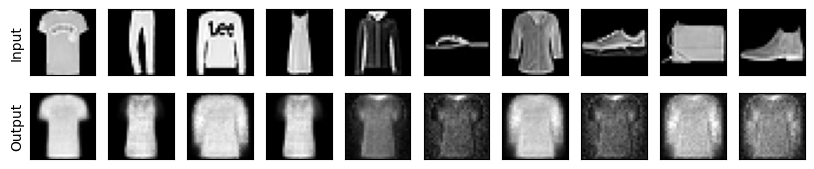

[Epoch 2]


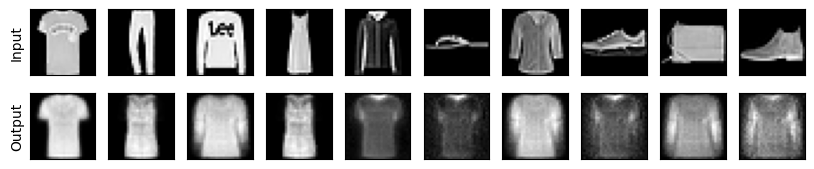

[Epoch 3]


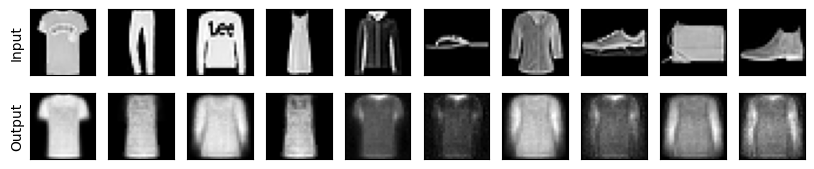

[Epoch 4]


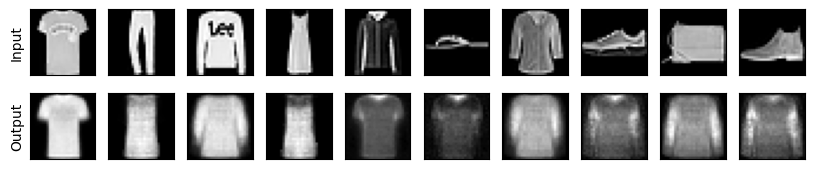

[Epoch 5]


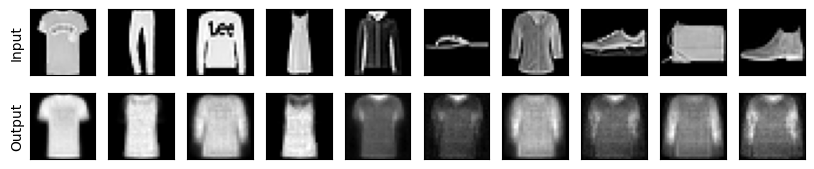

In [9]:
# Training process including visualization
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    f, a = plt.subplots(2, 10, figsize=(10, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(10):
        img = np.reshape(view_data.data.numpy()[i],(28, 28)) 
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())
        if(i == 0): a[0][i].set_ylabel('Input')

    for i in range(10):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28)) 
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
        if(i == 0): a[1][i].set_ylabel('Output')
    plt.show()

In [10]:
THRESHOLDVAL=0.01 # threshold val
dic_loss = {'id':[], 'label':[], 'score':[],'normal':[]}

count=0
for step, (x, label) in enumerate(test_loader):
    x = x.view(-1, 28*28).to(DEVICE)
    y = x.view(-1, 28*28).to(DEVICE) 

    encoded, decoded = autoencoder(x)
    loss = float(criterion(decoded, y).cpu().detach().numpy())
    dic_loss['id'].append(step)
    dic_loss['label'].append(int(label==SELECT_NORMAL)) # 1: normal, 0: abnormal
    dic_loss['score'].append(loss) # abnormal score
    if loss>THRESHOLDVAL: dic_loss['normal'].append('0')
    else: dic_loss['normal'].append('1')


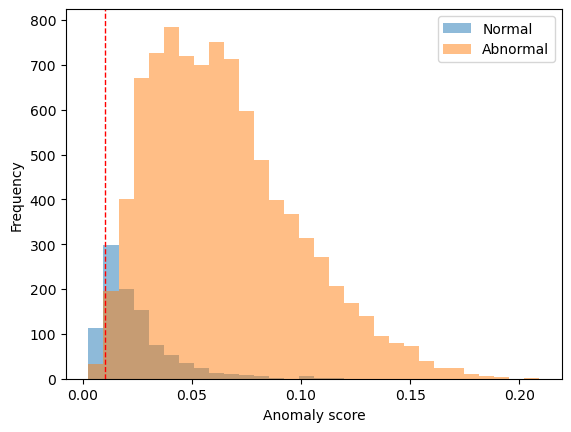

In [11]:
# Gernerating plot
arr_label = np.array(dic_loss['label'])
arr_score = np.array(dic_loss['score'])
score_min = arr_score.min()
score_max = arr_score.max()
plt.hist(arr_score[np.where(arr_label == 1)[0]], bins=30, range=(score_min, score_max), alpha=0.5, label='Normal')
plt.hist(arr_score[np.where(arr_label == 0)[0]], bins=30, range=(score_min, score_max), alpha=0.5, label='Abnormal')
plt.xlabel("Anomaly score")
plt.ylabel("Frequency")
plt.axvline(THRESHOLDVAL,0,1, color='red',linestyle='--',linewidth=1)
plt.legend(loc='upper right')
plt.savefig("plot.png")
plt.show()

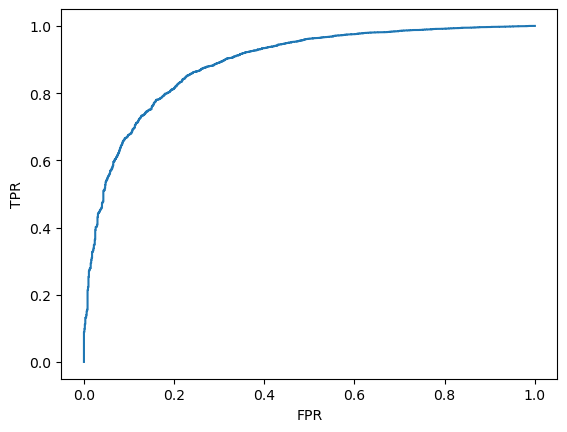

AUROC: 0.8896288888888888


In [12]:
# Generating ROC curve and AUROC
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
fpr, tpr, thresholds = roc_curve(dic_loss['label'], dic_loss['score'], pos_label=0)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("auroc.png")
plt.show()
auroc = auc(fpr, tpr)
print("AUROC: {}".format(auroc))

In [13]:
# Leveraging the pandas library to convert a dict to a dataframe is more convenient when checking values.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html
df = pd.DataFrame.from_dict(dic_loss)
df 

,id,label,score,normal
0,0,0,0.038019,0
1,1,0,0.035279,0
2,2,1,0.010376,0
3,3,0,0.085525,0
4,4,1,0.012508,0
...,...,...,...,...
9995,9995,0,0.066097,0
9996,9996,0,0.037025,0
9997,9997,0,0.115102,0
9998,9998,0,0.070970,0


In [14]:
# In order to submit .csv to kaggle, dataframe should fit following format
# id[1,2,3...,10000], predicted abnormaly[0,1,0....,0]

# 'pop('score,None')' delete one of the item in dict
# 'del df['item']', is also available.

# If you try to remove invalid itmes in the dict, the message that you set will be returned.
# set to None, nothing will be returned
dic_loss.pop('score',None)
dic_loss.pop('label',None)
df = pd.DataFrame.from_dict(dic_loss)
df

,id,normal
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
9995,9995,0
9996,9996,0
9997,9997,0
9998,9998,0


In [15]:
# to_csv will convert your dict to .csv file with the name of your teamnumber
# submit the .csv file to kaggle. If you upload proper .csv file to kaggle, you can check your result immediately.
teamnumber = 1 # insert your teamnumber
df.to_csv("result_team{}.csv".format(teamnumber), index =False) # Index should be not included in the .csv file.

In [16]:
# https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html
# you can save your weight.
torch.save(autoencoder.state_dict(), 'model_team{}.pth'.format(teamnumber))